In [1]:
# calculation
import numpy as np
from numpy.linalg import norm, eigvals, svd, eigvalsh, eigh
from scipy.linalg import sqrtm

# execution tracking
import time
from timeit import timeit

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

# helper functions
def is_complex(a):
    if hasattr(a, 'dtype'):
        return np.issubdtype(a.dtype, complex)
    return np.iscomplex(a).any()

def normalize(a, p=2, axis=0, remove_global_phase_if_1D=True):
    """ Normalize a given array. For complex 1d-arrays, a global phase is removed if `remove_global_phase_if_1D == True`. """
    if is_complex(a):
        a = np.array(a, dtype=complex)
    else:
        a = np.array(a, dtype=float)
    a /= norm(a, ord=p, axis=axis, keepdims=True)
    if len(a.shape) == 1 and remove_global_phase_if_1D and is_complex(a):
        # this works only for a 1D array
        a *= np.exp(-1j*np.angle(a[0]))
    return a

def random_vec(size):
    x = np.random.random(size)
    y = np.random.random(size)
    return x + 1j*y

def random_dm(n=1, pure=False):
    """ Generate a random density matrix. """
    if pure:
        ket = normalize(random_vec(2**n))
        return np.outer(ket, ket.conj())
    else:
        probs = normalize(np.random.random(2**n), p=1)
        kets = normalize(random_vec((2**n, 2**n)))
        return kets @ np.diag(probs) @ kets.conj().T

def sqrtmh(A):
    """ Matrix square root for Hermitian matrices using eigendecomposition """
    w, v = eigh(A)
    return v @ np.diag(np.sqrt(w)) @ v.conj().T

def sqrtm_svd(A):
    """ Matrix square root for PSD matrices using SVD """
    u, s, vh = svd(A)
    return u @ np.diag(np.sqrt(s)) @ vh

def comm(s1, s2):
    """ Commutator of two matrices """
    return s1 @ s2 - s2 @ s1

In [2]:
# spectrum has cyclic property
for _ in range(1000):
    n = 10
    A = random_vec((n,n))
    B = random_vec((n,n))
    assert np.allclose(sorted(eigvals(A@B)), sorted(eigvals(B@A)))

# spectral mapping theorem

def matop(op, A):
    evals, evecs = np.linalg.eig(A)
    return evecs @ np.diag(op(evals, dtype=complex)) @ evecs.conj().T

def allclose_set(a, b):
    matched_b_indices = []
    for item_a in a:
        for i, item_b in enumerate(b):
            if i not in matched_b_indices and np.isclose(item_a, item_b):
                matched_b_indices.append(i)
                break
    return len(matched_b_indices) == len(a)

for it in range(100):
    A = random_dm(2)
    op = np.sqrt
    A1 = op(eigvals(A))
    A2 = eigvals(matop(op, A))
    assert allclose_set(A1, A2), f"{it}:\n  {r(A1,10)} \n≠ {r(A2,10)} \n {r(A1-A2,10)}"

In [3]:
def fidelity_def(rho, sig):
    """ Textbook definition """
    rho_sqrt = sqrtmh(rho)
    return np.trace(sqrtmh(rho_sqrt @ sig @ rho_sqrt))**2

def fidelity_own(rho, sig):
    """ Tr(sqrt(sqrt(rho) @ sig @ sqrt(rho))) = sum(sqrt(eigvals(rho @ sig))) = Tr(sqrt(rho @ sig)) """
    # return np.sum(eigvals(sqrtm(rho @ sig)))**2
    return np.sum(np.sqrt(eigvals(rho @ sig).real))**2  # rho @ sig is generally not normal, but still has non-negative eigenvalues

for _ in range(10000):
    rho = random_dm(2)
    sig = random_dm(2)
    assert not np.allclose(comm(rho, sig), 0)
    f1 = fidelity_def(rho, sig)
    f2 = fidelity_own(rho, sig)
    assert np.allclose(f1, f2)
print("All the same and no pair commuted!")

def _test_fidelity(fidelity):
    # same state
    rho = random_dm(5)
    assert np.allclose(fidelity(rho, rho), 1), f"fidelity = {fidelity(rho, rho)} ≠ 1"

    # orthogonal states
    rho1 = np.array([[1, 0], [0, 0]])
    rho2 = np.array([[0, 0], [0, 1]])
    assert np.allclose(fidelity(rho1, rho2), 0), f"fidelity = {fidelity(rho1, rho2)} ≠ 0"

    # F(s1,s2) \in [0,1] and symmetric
    rho1 = random_dm(5)
    rho2 = random_dm(5)
    assert 0 <= fidelity(rho1, rho2) <= 1, f"fidelity = {fidelity(rho1, rho2)} ∉ [0,1]"
    assert np.allclose(fidelity(rho1, rho2), fidelity(rho2, rho1)), f"fidelity(rho1, rho2) = {fidelity(rho1, rho2)} ≠ {fidelity(rho2, rho1)}"

    return True

_test_fidelity(fidelity_def)
_test_fidelity(fidelity_own)

All the same and no pair commuted!


True

Loading from data file: fidelity_times.npy


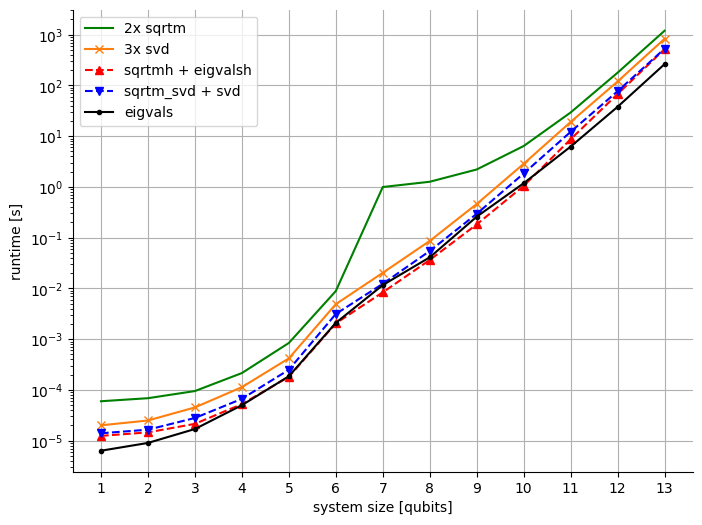

In [4]:
# compare the runtimes of different implementations
def fidelity_slow1(rho, sig):
    """ Fidelity using sqrtm """
    sqrt_rho = sqrtm(rho)
    return np.sum(eigvals(sqrtm(sqrt_rho @ sig @ sqrt_rho)))**2

def fidelity_slow2(rho, sig):
    """ Fidelity using three svds """
    sqrt_rho = sqrtm_svd(rho)
    sqrt_sig = sqrtm_svd(sig)
    return np.sum(svd(sqrt_rho @ sqrt_sig, compute_uv=False))**2

def fidelity_fast1(rho, sig):
    """ Fidelity using sqrtmh and eigvalsh """
    sqrt_rho = sqrtmh(rho)
    return np.sum(np.sqrt(eigvalsh(sqrt_rho @ sig @ sqrt_rho)))**2

def fidelity_fast2(rho, sig):
    """ Fidelity using sqrtm_svd and svd """
    sqrt_rho = sqrtm_svd(rho)
    return np.sum(np.sqrt(svd(sqrt_rho @ sig @ sqrt_rho, compute_uv=False)))**2

def fidelity_fast3(rho, sig):
    """ Fidelity using eigvals """
    return np.sum(np.sqrt(eigvals(rho @ sig).real))**2

# check they are correct
assert _test_fidelity(fidelity_slow1)
assert _test_fidelity(fidelity_slow2)
assert _test_fidelity(fidelity_fast1)
assert _test_fidelity(fidelity_fast2)
assert _test_fidelity(fidelity_fast3)

rho = random_dm(5)
sig = random_dm(5)
assert np.allclose(fidelity_slow1(rho, sig), fidelity_slow2(rho, sig))
assert np.allclose(fidelity_slow2(rho, sig), fidelity_fast1(rho, sig))
assert np.allclose(fidelity_fast1(rho, sig), fidelity_fast2(rho, sig))
assert np.allclose(fidelity_fast2(rho, sig), fidelity_fast3(rho, sig))

def runtime2(n):
    runs = int(np.ceil(10000/2**(n-3)))
    print(f"n = {n} ({runs} runs)")

    rho = random_dm(n)
    sig = random_dm(n)

    def run_and_show(f, name):
        print(f"  {name}", end=" ")
        time = timeit(lambda: f(rho, sig), number=runs)/runs
        print(f"  {time:.6f} s")
        return time

    # collect the average runtime over 12 runs
    times = []
    times.append(run_and_show(fidelity_slow1, "2x sqrtm         "))
    times.append(run_and_show(fidelity_slow2, "3x svd           "))
    times.append(run_and_show(fidelity_fast1, "sqrtmh + eigvalsh"))
    times.append(run_and_show(fidelity_fast2, "sqrtm_svd + svd  "))
    times.append(run_and_show(fidelity_fast3, "eigvals          "))
    return times

# set a file name here to load past runs
datafile = None  # "fidelity_times.npy"

if datafile is None:
    ns = list(range(1,14))
    times = []
    datafile = f"fidelity_times_{time.time():.0f}"
    print(f"Saving to data file: {datafile}.npy")
    for n in ns:
        times.append(runtime2(n))
        np.save(datafile, times)
    times = np.array(times)
else:
    print(f"Loading from data file: {datafile}")
    times = np.load(datafile)
    ns = list(range(1,len(times)+1))

# import rsmf
# fmt = rsmf.setup("main.tex")
# fig = fmt.figure(0.9,1.3)
plt.figure(figsize=(8,6))

plt.plot(ns, times[:,0], label="2x sqrtm", marker=None, linestyle="-", color="green")
plt.plot(ns, times[:,1], label="3x svd", marker="x", linestyle="-", color="C1")
plt.plot(ns, times[:,2], label="sqrtmh + eigvalsh", marker="^", linestyle="--", color="red")
plt.plot(ns, times[:,3], label="sqrtm_svd + svd", marker="v", linestyle="--", color="blue")
plt.plot(ns, times[:,4], label="eigvals", marker=".", linestyle="-", color="k")
plt.yscale("log")
plt.xlabel("system size [qubits]")
plt.ylabel("runtime [s]")
plt.legend()
plt.grid()
plt.tick_params(axis='y', which='minor')
# remove top and right border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# x axis
# ax.set_xlim(ns[0], ns[-1])
ax.set_xticks(ns)
# y axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, numticks=10, subs=np.arange(2, 10) * .1))

plt.savefig("performance_comparison", bbox_inches="tight")
None

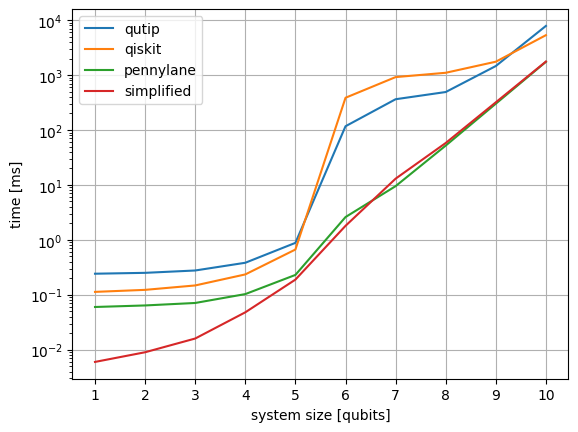

In [5]:
# import qutip
# from qutip import fidelity as fidelity_qutip
# import qiskit
# from qiskit.quantum_info import state_fidelity as fidelity_qiskit
# from pennylane.math import fidelity as fidelity_pennylane

# import warnings; warnings.simplefilter('ignore')  # turn qiskit warnings off

# def runtime(n):
#     print(f"n = {n}")
#     rho = random_dm(n)
#     sig = random_dm(n)
#     print("  qutip    ", end=" ")
#     # make them qutip objects
#     rho_ = qutip.Qobj(rho)
#     sig_ = qutip.Qobj(sig)
#     %timeit fidelity_qutip(rho_, sig_)**2
#     print("  qiskit   ", end=" ")
#     # make them qiskit objects
#     rho_ = qiskit.quantum_info.DensityMatrix(rho)
#     sig_ = qiskit.quantum_info.DensityMatrix(sig)
#     %timeit fidelity_qiskit(rho_, sig_)
#     print("  pennylane", end=" ")
#     %timeit fidelity_pennylane(rho, sig)
#     print("  own      ", end=" ")
#     %timeit fidelity_own(rho, sig)

# for n in range(1,11):
#     runtime(n)

ns = list(range(1,11))
# empirical results (Apple M1 chip, 16GB RAM)
plt.plot(ns, [0.242, 0.251, 0.277, 0.383, 0.882, 117, 363,  491, 1460, 7840], label="qutip")
plt.plot(ns, [0.113, 0.123, 0.148, 0.235, 0.667, 386, 918, 1100, 1750, 5320], label="qiskit")
plt.plot(ns, [0.060, 0.064, 0.071, 0.103, 0.230, 2.6, 9.5,   52,  301, 1740], label="pennylane")
plt.plot(ns, [0.006, 0.009, 0.016, 0.048, 0.189, 1.8,  13,   58,  319, 1760], label="simplified")
plt.yscale("log")
plt.xlabel("system size [qubits]")
plt.ylabel("time [ms]")
plt.legend()
plt.xticks(ns)
plt.grid()
None